In [11]:
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum

from ParallelSolve_copy import gurobi_network_first_stage, majority_vote_network

In [12]:
rng = np.random.default_rng(seed = 2024)
def sample_func(rng, distribution_name, **dist_params):
     if hasattr(rng, distribution_name):
        dist_func = getattr(rng, distribution_name)
        samples = dist_func(**dist_params)
        return samples + 1 if distribution_name == "pareto" else samples
     else:
        raise ValueError(f"Unsupported distribution: {distribution_name}")

In [13]:
def gurobi_second_stage(sample_S, sample_D, C, Q_sp, Q_pc, R, M, H, x):
    # second stage LP problem
    s, p, g = Q_sp.shape
    c, g, k = sample_D.shape
    model = Model("second_stage")
    model.setParam(GRB.Param.OutputFlag, 0)
    y_sp = model.addVars(s, p, g, k, lb=0, vtype=GRB.CONTINUOUS, name="y_sp")
    y_pc = model.addVars(p, c, g, k, lb=0, vtype=GRB.CONTINUOUS, name="y_pc")
    z = model.addVars(c, g, k, lb=0, vtype=GRB.CONTINUOUS, name="z")

    obj_expr = 1/k * quicksum(Q_sp[i, j, l] * y_sp[i, j, l, a] for i in range(s) for j in range(p) for l in range(g) for a in range(k))\
                        + 1/k * quicksum(Q_pc[j, i, l] * y_pc[j, i, l, a] for j in range(p) for i in range(c) for l in range(g) for a in range(k))\
                            + 1/k * quicksum(H[i, l] * z[i, l, a] for i in range(c) for l in range(g) for a in range(k))
    
    model.setObjective(obj_expr, GRB.MINIMIZE)

    model.addConstrs((quicksum(y_sp[i, j, l, a] for i in range(s)) - quicksum(y_pc[j, i, l, a] for i in range(c)) == 0
                        for a in range(k) for l in range(g) for j in range(p)), name="flow")
    
    model.addConstrs((quicksum(y_pc[j, i, l, a] + z[i, l, a] for j in range(p)) >= sample_D[i, l, a]
                        for a in range(k) for l in range(g) for i in range(c)), name="demand")
    
    model.addConstrs((quicksum(y_sp[i, j, l, a] for j in range(p)) <= sample_S[i, l, a]
                        for a in range(k) for l in range(g) for i in range(s)), name="supply")
    
    model.addConstrs((quicksum(R[j, l] * quicksum(y_sp[i, j, l, a] for i in range(s)) for l in range(g)) <= M[j] * x[j]
                        for a in range(k) for j in range(p)), name="capacity")
    
    model.optimize()

    if model.status == GRB.OPTIMAL:
        return model.ObjVal + sum(C[j] * x[j] for j in range(p)) 
    else:
        print("No optimal solution found.")
        return None
    

In [14]:
def comparison(parameters,a_ls,B,number_of_iterations,ratio,sample_number, rng):
    C, Q_sp, Q_pc, R, M, H = parameters['C'], parameters['Q_sp'], parameters['Q_pc'], parameters['R'], parameters['M'], parameters['H']
    a_S, a_D = a_ls[0], a_ls[1]

    SAA_list = []
    majority_list = []
    for n in sample_number:
        SAA_intermediate = []
        majority_intermediate = []
        for _ in range(number_of_iterations):
            sample_S = sample_func(rng, 'pareto', size=(s,g,n), a=a_S)
            sample_D = sample_func(rng, 'pareto', size=(c,g,n), a=a_D)

            SAA = majority_vote_network(sample_S,sample_D, 1, n, gurobi_network_first_stage, rng, C, Q_sp, Q_pc, R, M, H)
            SAA_intermediate.append(tuple([round(x) for x in SAA]))

            majority = majority_vote_network(sample_S, sample_D, B, int(n*ratio), gurobi_network_first_stage, rng, C, Q_sp, Q_pc, R, M, H)
            majority_intermediate.append(tuple([round(x) for x in majority]))
            
        SAA_list.append(SAA_intermediate)
        majority_list.append(majority_intermediate)
    
    return SAA_list, majority_list

def evaluation_CI(SAA_list, majority_list, parameters, a_ls, number_of_iterations, sample_number, large_number_sample, rng):
    C, Q_sp, Q_pc, R, M, H = parameters['C'], parameters['Q_sp'], parameters['Q_pc'], parameters['R'], parameters['M'], parameters['H']
    a_S, a_D = a_ls[0], a_ls[1]
    
    def unique_solutions(lists):
        unique_sols = []
        for sublist in lists:
            for item in sublist:
                if item not in unique_sols:
                    unique_sols.append(item)
        return unique_sols
    
    all_solutions = unique_solutions(SAA_list + majority_list)
    solution_obj_values = {str(solution): 0 for solution in all_solutions}

    for solution in all_solutions:
        large_sample_S = sample_func(rng, 'pareto', size=(s,g,large_number_sample), a=a_S)  
        large_sample_D = sample_func(rng, 'pareto', size=(c,g,large_number_sample), a=a_D)
        obj_value = gurobi_second_stage(large_sample_S, large_sample_D, C, Q_sp, Q_pc, R, M, H, solution)
        solution_obj_values[str(solution)] = obj_value
    
    SAA_obj_lists, majority_obj_lists, SAA_obj_list, majority_obj_list = [], [], [], []
    for i in range(len(sample_number)):
        current_SAA_obj_list = []
        current_majority_obj_list = []
        for j in range(number_of_iterations):
            SAA_obj = solution_obj_values[str(SAA_list[i][j])]
            majority_obj = solution_obj_values[str(majority_list[i][j])]
            current_SAA_obj_list.append(SAA_obj)
            current_majority_obj_list.append(majority_obj)
        
        SAA_obj_lists.append(current_SAA_obj_list)
        majority_obj_lists.append(current_majority_obj_list)
        SAA_obj_list.append(np.mean(current_SAA_obj_list))
        majority_obj_list.append(np.mean(current_majority_obj_list))

    return SAA_obj_lists, majority_obj_lists, SAA_obj_list, majority_obj_list


def figure_plot(SAA_obj_list, majority_obj_list,sample_number):
    # plot the objective values of SAA and Bagging-SAA
    _, ax = plt.subplots()
    ax.plot(sample_number, SAA_obj_list, marker = 'o', markeredgecolor = 'none', color = 'blue',linestyle = 'solid', linewidth = 2, label = 'SAA')
    ax.plot(sample_number, majority_obj_list, marker = 's', markeredgecolor = 'none', color = 'red',linestyle = 'solid', linewidth = 2, label = 'Majority Vote')
    ax.set_xlabel('Number of samples', size = 20)
    ax.set_ylabel('Objective', size = 20)
    ax.legend(loc = 'lower right')
    plt.show()
    return

In [15]:
# Run script with a single set of random parameters

s = 3 # number of suppliers
p = 2 # number of facilities
c = 3 # number of consumers
g = 5 # number of products

# Randomly generate input parameters based on the given dimensions
parameters = {
    'C': np.random.rand(p),           # Unit cost for building a facility
    'Q_sp': np.random.rand(s, p, g),  # Unit flow cost from supplier to facility
    'Q_pc': np.random.rand(p, c, g),  # Unit flow cost from facility to customer
    'R': np.random.rand(p, g),        # Unit processing requirement
    'M': np.random.rand(p),           # Processing capacity
    'H': np.random.rand(c, g)        # Multiplier
}

# Pareto distribution parameter for S and D, make sure the supply is larger than demand
a_ls = np.array([np.random.uniform(1.9,2), np.random.uniform(2,2.1)]) 

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13


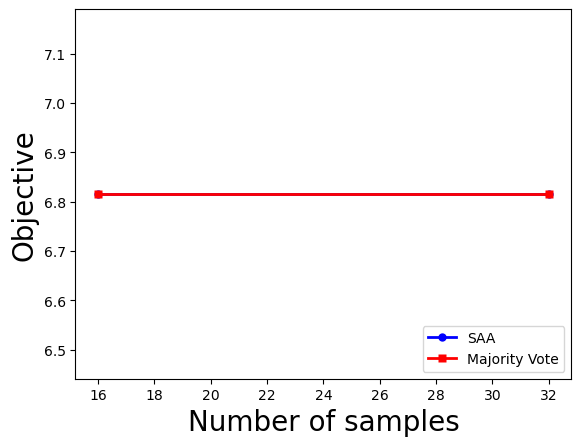

In [17]:
B = 200
number_of_iterations = 20
ratio = 0.1
sample_number = np.array([2**i for i in range(6, 16)])
large_number_sample = 200000

SAA_list, majority_list = comparison(parameters,a_ls,B,number_of_iterations,ratio,sample_number, rng)
SAA_obj_lists, majority_obj_lists, SAA_obj_list, majority_obj_list = evaluation_CI(SAA_list, majority_list, parameters, a_ls, number_of_iterations, sample_number, large_number_sample, rng)
figure_plot(SAA_obj_list, majority_obj_list, sample_number)

In [ ]:
# repeated experiments
s = 3 # number of suppliers
p = 2 # number of facilities
c = 3 # number of consumers
g = 5 # number of products

B = 200
number_of_iterations = 20
ratio = 0.1
sample_number = np.array([2**i for i in range(6, 16)])
large_number_sample = 200000

results_list = []
for _ in range(20):
    # TODO: May need to adjust the range of random number generation/ fix some parameters
    parameters = {
        'C': np.random.rand(p),           # Unit cost for building a facility
        'Q_sp': np.random.rand(s, p, g),  # Unit flow cost from supplier to facility
        'Q_pc': np.random.rand(p, c, g),  # Unit flow cost from facility to customer
        'R': np.random.rand(p, g),        # Unit processing requirement
        'M': np.random.rand(p),           # Processing capacity
        'H': np.random.rand(c, g)        # Multiplier
    }
    
    # Pareto distribution parameter for S and D, make sure the supply is larger than demand
    # TODO: May need to adjust the range of random sample generation
    a_ls = np.array([np.random.uniform(1.9,2), np.random.uniform(2,2.1)])
    
    SAA_list, majority_list = comparison(parameters,a_ls,B,number_of_iterations,ratio,sample_number, rng)
    SAA_obj_lists, majority_obj_lists, SAA_obj_list, majority_obj_list = evaluation_CI(SAA_list, majority_list, parameters, a_ls, number_of_iterations, sample_number, large_number_sample, rng)
    result_dict = {
        'parameters': parameters,
        'a_ls': a_ls,
        'SAA_obj_lists': SAA_obj_lists,
        'majority_obj_lists': majority_obj_lists,
        'SAA_obj_list': SAA_obj_list,
        'majority_obj_list': majority_obj_list
    }
    results_list.append(result_dict)
    

In [ ]:
for result in results_list:
    print(f"Parameters: {result['parameters']}, a_ls: {result['a_ls']}")
    figure_plot(result['SAA_obj_list'], result['majority_obj_list'], sample_number)